/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


[Errno 2] No such file or directory: 'KAN_Stocks'
/teamspace/studios/this_studio/KAN_Stocks
Train batch_features shape: 
torch.Size([32, 25])
Train batch_targets shape: 
torch.Size([32])
Validation batch_features shape: 
torch.Size([32, 25])
Validation batch_targets shape: 
torch.Size([32])
4453


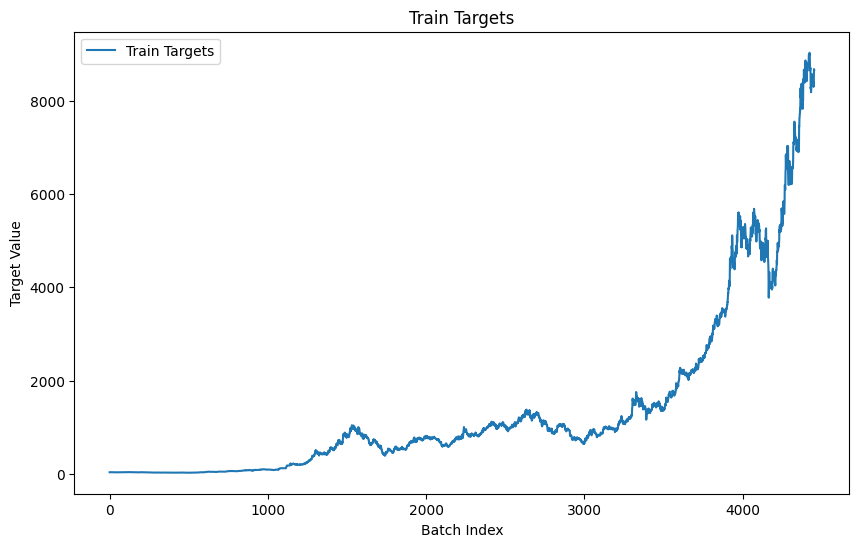

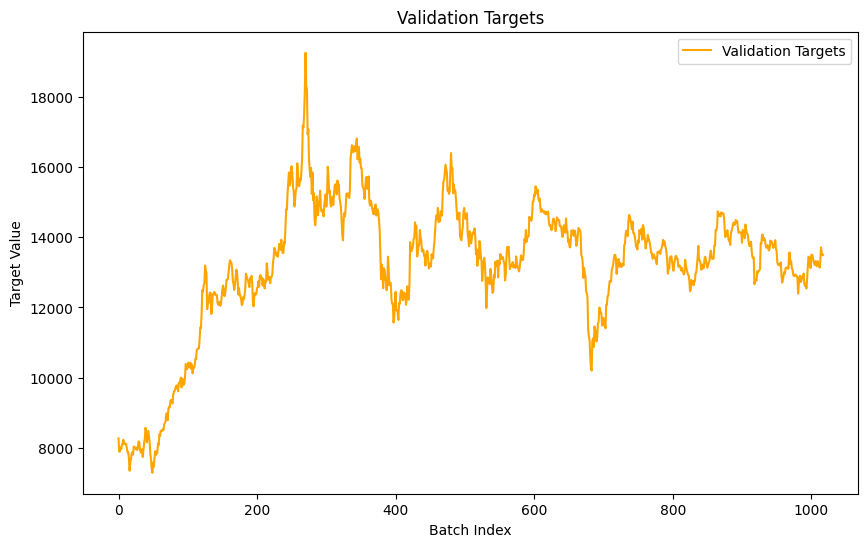

In [15]:
%cd KAN_Stocks
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv('stock_data_engi.csv')

# 转换数据类型
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = pd.to_numeric(data[column], errors='coerce')

# 用后值填充NaN
data = data.bfill()
data = data.ffill()

# 转换数据类型
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = pd.to_numeric(data[column], errors='coerce')

# 划分训练集和验证集
train_data = data[data['year'] <= 2019]
val_data = data[data['year'] > 2019]

# 定义 Dataset 类
class StockDataset(Dataset):
    def __init__(self, data, mean=None, std=None):
        self.data = data
        self.features = data.drop(columns=['收盘价(元)', '代码', '简称', '日期', '年份', '月份']).values.astype(np.float32)
        self.targets = data['收盘价(元)'].values.astype(np.float32)

        if mean is None or std is None:
            self.mean = self.features.mean(axis=0)
            self.std = self.features.std(axis=0)
        else:
            self.mean = mean
            self.std = std

        # Z-score 标准化
        self.features = (self.features - self.mean) / self.std

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature = self.features[idx]
        target = self.targets[idx]
        return torch.tensor(feature), torch.tensor(target)

# 创建训练集和验证集实例
train_dataset = StockDataset(train_data)
val_dataset = StockDataset(val_data, mean=train_dataset.mean, std=train_dataset.std)

# 创建 DataLoader，不打乱数据顺序
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 测试 DataLoader
for batch_features, batch_targets in train_loader:
    print("Train batch_features shape: ")
    print(batch_features.shape)
    print("Train batch_targets shape: ")
    print(batch_targets.shape)
    break  # 只测试一个批次

for batch_features, batch_targets in val_loader:
    print("Validation batch_features shape: ")
    print(batch_features.shape)
    print("Validation batch_targets shape: ")
    print(batch_targets.shape)
    break  # 只测试一个批次

# 可视化训练集的 target 数据
train_targets = []
for _, targets in train_loader:
    train_targets.extend(targets.tolist())

print(len(train_targets))

plt.figure(figsize=(10, 6))
plt.plot(train_targets, label='Train Targets')
plt.title('Train Targets')
plt.xlabel('Batch Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()

# 可视化验证集的 target 数据
val_targets = []
for _, targets in val_loader:
    val_targets.extend(targets.tolist())

plt.figure(figsize=(10, 6))
plt.plot(val_targets, label='Validation Targets', color='orange')
plt.title('Validation Targets')
plt.xlabel('Batch Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
# 导入 KAN 模块
from KAN import KAN

# 实例化模型
input_dim = 25
hidden_layers = [input_dim, 64, 64, 1]  # 隐藏层维度列表
model = KAN(layers_hidden=hidden_layers)

# 生成dummy tensor
dummy_features = torch.randn(32,25)  # (batch_size, sequence_length, in_features)
dummy_targets = torch.randn(32)           # (batch_size)

# 前向传播测试
outputs = model(dummy_features)

# 打印输出维度
print("Output shape:", outputs.shape)  # 应该是 (batch_size, output_size)

# 计算均方误差损失
criterion = nn.MSELoss()
loss = criterion(outputs.view(-1), dummy_targets)  # 将输出展平成一维以匹配目标维度
print("MSE Loss:", loss.item())


Output shape: torch.Size([32, 1])
MSE Loss: 1.118127465248108


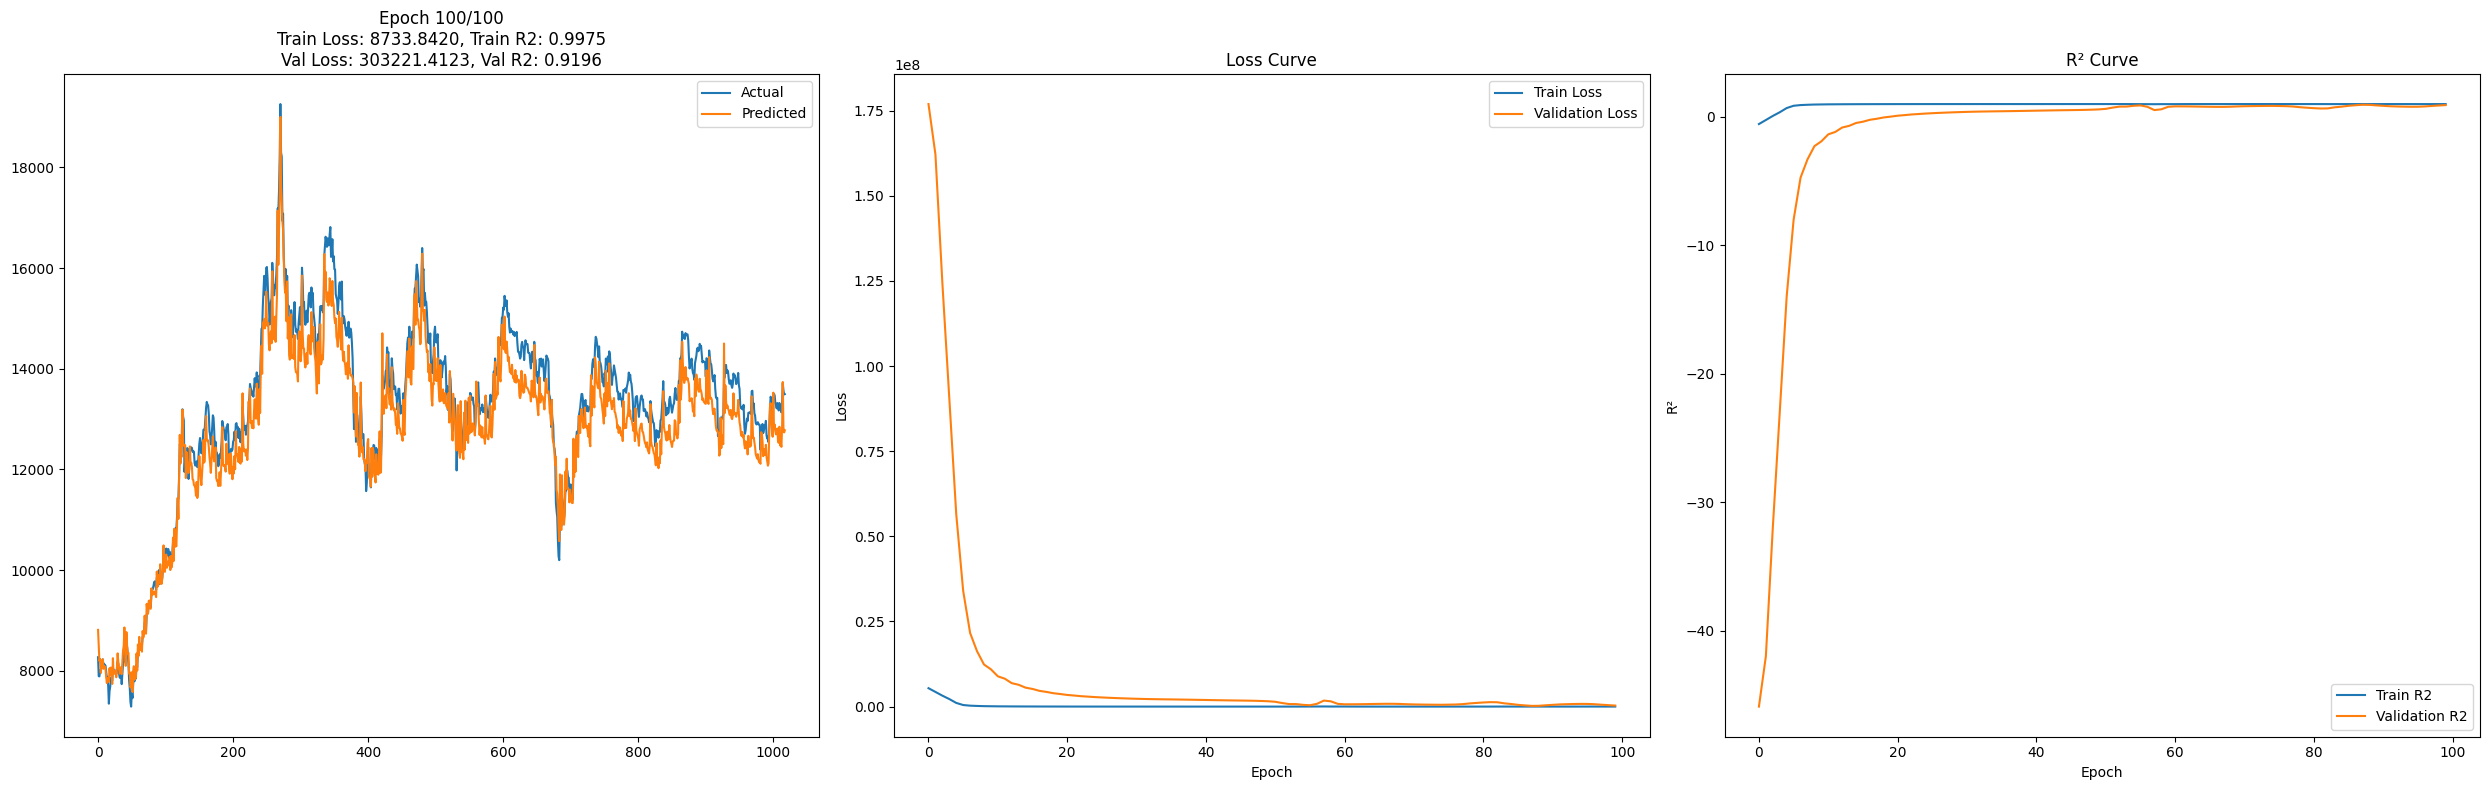

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import csv

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 训练和验证函数
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    y_true = []
    y_pred = []
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * features.size(0)
        y_true.extend(targets.tolist())
        y_pred.extend(outputs.view(-1).tolist())
    train_loss /= len(train_loader.dataset)
    train_r2 = r2_score(y_true, y_pred)
    return train_loss, train_r2

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for features, targets in val_loader:
            outputs = model(features)
            loss = criterion(outputs.view(-1), targets)
            val_loss += loss.item() * features.size(0)
            y_true.extend(targets.tolist())
            y_pred.extend(outputs.view(-1).tolist())
    val_loss /= len(val_loader.dataset)
    val_r2 = r2_score(y_true, y_pred)
    return val_loss, val_r2, y_true, y_pred

# 记录训练和验证的指标
train_losses = []
val_losses = []
train_r2s = []
val_r2s = []

with open('training_log.csv', 'w', newline='') as csvfile:
    fieldnames = ['epoch', 'train_loss', 'train_r2', 'val_loss', 'val_r2']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # 训练和验证过程
    num_epochs = 100
    for epoch in range(num_epochs):
        train_loss, train_r2 = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_r2, y_true, y_pred = validate(model, val_loader, criterion)

        # 记录指标到 CSV 文件
        writer.writerow({'epoch': epoch + 1, 'train_loss': train_loss, 'train_r2': train_r2, 'val_loss': val_loss, 'val_r2': val_r2})

        # 记录指标到列表
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_r2s.append(train_r2)
        val_r2s.append(val_r2)

        # 清除前一个输出
        clear_output(wait=True)

        # 创建一个 figure，包含三个子图
        fig, axs = plt.subplots(1, 3, figsize=(25, 8))

        # 绘制实际和预测的走势图
        axs[0].plot(y_true, label='Actual')
        axs[0].plot(y_pred, label='Predicted')
        axs[0].set_title(f'Epoch {epoch+1}/{num_epochs}\nTrain Loss: {train_loss:.4f}, Train R2: {train_r2:.4f}\nVal Loss: {val_loss:.4f}, Val R2: {val_r2:.4f}')
        axs[0].legend()

        # 绘制 Loss 曲线
        axs[1].plot(train_losses, label='Train Loss')
        axs[1].plot(val_losses, label='Validation Loss')
        axs[1].set_title('Loss Curve')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend()

        # 绘制 R² 曲线
        axs[2].plot(train_r2s, label='Train R2')
        axs[2].plot(val_r2s, label='Validation R2')
        axs[2].set_title('R² Curve')
        axs[2].set_xlabel('Epoch')
        axs[2].set_ylabel('R²')
        axs[2].legend()

        # 显示图表
        plt.tight_layout()
        plt.show()


---